# it`s not official just use it as a test#

In [25]:
import camelot
from langchain.text_splitter import CharacterTextSplitter
from dotenv import load_dotenv
import arabic_reshaper
from bidi.algorithm import get_display
from joblib import Memory
from pdf2image import convert_from_path
from PIL import Image
import pytesseract
import os

In [26]:

# Define a directory for cache storage
memory = Memory("./cache_dir", verbose=0)


In [27]:
@memory.cache
def get_pdf_tables(pdf_docs):
    pdfs_reader = []
    for pdf in pdf_docs:
        pdf_reader = camelot.read_pdf(pdf,pages='all',) #address of pdf file(pdf)
        pdfs_reader.append(pdf_reader)
    return pdfs_reader



def fix_arabic_text(cell): # Fix Arabic text direction
    try:
        reshaped_text = arabic_reshaper.reshape(cell)  # Reshape Arabic characters
        bidi_text = get_display(reshaped_text)  # Apply BiDi algorithm
        return bidi_text
    except Exception:
        return cell  # Return as is if not Arabic
    

In [28]:
directory_path = r".\documents"

pdf_files = []
for root, dirs, files in os.walk(directory_path):
    for file in files:
        if file.endswith('.pdf'):
            pdf_files.append(os.path.join(root, file))

# Print the list of PDF files with their paths
print("PDF files found:")
for pdf_file in pdf_files:
    print(pdf_file)


PDF files found:
.\documents\الاثنين 16-12-2024 د19 القاهرة الجديدة.pdf
.\documents\الاثنين جلسة 1-1-2024 د19.pdf
.\documents\الاثنين جلسة 1-4-2024 د19 وراثات.pdf
.\documents\د(19)اسرة السيدة زينب 22-12-2024.pdf
.\documents\د(20)اسرة باب الشعرية 19-12-2024.pdf
.\documents\د(20)اسرة عابدين18-12-2024.pdf
.\documents\د(22) اسرة  الموسكى  جلسة 21-12-2024.pdf
.\documents\ورثات الزاوية 16-12.pdf
.\documents\ورثات الشرابية 17-12.pdf


In [29]:
pdfs_tables = get_pdf_tables(pdf_files)

print(pdfs_tables)


invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11479'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11479'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11479'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11479'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11479'
incorrect star

[<TableList n=6>, <TableList n=4>, <TableList n=1>, <TableList n=3>, <TableList n=5>, <TableList n=5>, <TableList n=2>, <TableList n=1>, <TableList n=2>]


In [34]:
def get_head_from_first_page(pdf): # Get the head of the table from the first page only of each PDF
        first_page = pdf[0]
        first_page.df = first_page.df.map(fix_arabic_text)
        # Access the table's structure
        cells = first_page.cells  # List of all detected cells
        head = f"{cells[0][0].x1}, {cells[0][0].y2}, {cells[0][-1].x2}, {cells[0][0].y1}"
        return head
head_coordinates = {}
for i in range (len(pdfs_tables)):
    print(i)
    head_coordinates[i]=get_head_from_first_page(pdfs_tables[i])
print(head_coordinates)

0
1
2
3
4
5
6
7
8
{0: '19.921338334108565, 822.2581242873432, 575.1986688180718, 619.2588369441278', 1: '19.92133879190301, 822.2581242873432, 575.1986688180718, 638.220638540479', 2: '19.91383874546188, 822.2581242873432, 575.1986688180718, 664.1431014823261', 3: '19.92133879190301, 822.2581242873432, 575.1986688180718, 619.2588369441278', 4: '19.92133741851967, 822.2581242873432, 575.1986688180718, 619.2588369441278', 5: '19.92133879190301, 822.2581242873432, 575.1986688180718, 619.2588369441278', 6: '19.92133741851967, 822.2581242873432, 575.1986688180718, 619.2588369441278', 7: '19.921324600275128, 822.2581242873432, 575.1986688180718, 664.1431014823261', 8: '19.92122205431878, 822.2581242873432, 575.1986688180718, 664.1431014823261'}


## You don`t need to run this cell


invalid pdf header: b'11724'
incorrect startxref pointer(1)


parsing for Object Streams


.\documents\الاثنين 16-12-2024 د19 القاهرة الجديدة.pdf 0


invalid pdf header: b'11479'
incorrect startxref pointer(1)
parsing for Object Streams


.\documents\الاثنين جلسة 1-1-2024 د19.pdf 1


invalid pdf header: b'15576'
incorrect startxref pointer(3)
parsing for Object Streams


.\documents\الاثنين جلسة 1-4-2024 د19 وراثات.pdf 2


invalid pdf header: b'11710'
incorrect startxref pointer(1)
parsing for Object Streams


.\documents\د(19)اسرة السيدة زينب 22-12-2024.pdf 3


KeyboardInterrupt: 

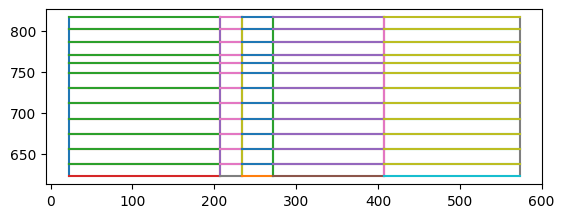

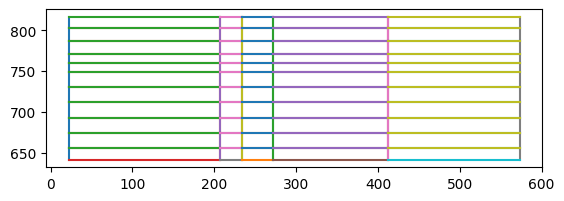

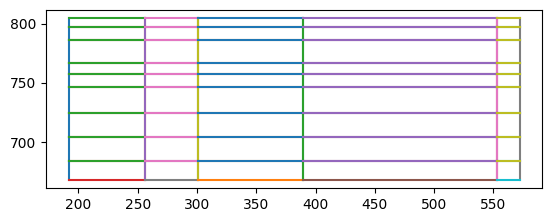

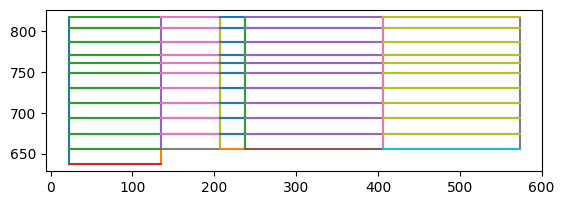

In [35]:
def check_on_pdf_grid(pdf_path,key):
    file_name =os.path.basename(pdf_path)
    nested_tables = camelot.read_pdf(pdf_path, pages='1',flavor='stream',table_areas=[head_coordinates[key]],edge_tol=500,)
    camelot.plot(table=nested_tables[0], kind="grid")
    
for pdf_path,key in zip(pdf_files,head_coordinates):
    print(pdf_path,key)
    check_on_pdf_grid(pdf_path,key)

In [36]:
#get the first page of each pdf as an image
pages_images = []
for pdf_path,key in zip(pdf_files,head_coordinates):
    # Convert the PDF page to an image
    pages = convert_from_path(pdf_path, first_page=1, last_page=1, dpi=300,poppler_path=r".\libs\poppler-24.08.0\Library\bin")
    pages_images.append(pages[0])
    
print(pages_images)

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x262AC38FBB0>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x262AC38EF20>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2629CB17280>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2629CB16F80>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2629CB17250>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2629CB17220>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2629CB17040>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2629CB171F0>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2629CB17100>]


In [37]:
#convert head_coordinates to list of int
head_coordinates_int = {}
for key in head_coordinates:
    head_coordinates_int[key] = [int(float(coord)) for coord in head_coordinates[key].split(",")]
    
print(head_coordinates_int)

{0: [19, 822, 575, 619], 1: [19, 822, 575, 638], 2: [19, 822, 575, 664], 3: [19, 822, 575, 619], 4: [19, 822, 575, 619], 5: [19, 822, 575, 619], 6: [19, 822, 575, 619], 7: [19, 822, 575, 664], 8: [19, 822, 575, 664]}


In [40]:
for i,page_image in enumerate(pages_images):
    cropped_cell_image = page_image.crop((head_coordinates_int[i][0], 0, page_image.width,(page_image.height/100)+head_coordinates_int[i][1]))
    # Perform OCR on the cropped cell
    ocr_result = pytesseract.image_to_string(cropped_cell_image, lang="ara",config='--oem 3 --psm 6',)  # Add 'ara' for Arabic support
    print(ocr_result, "\n###############################################\n")
    # Save the cropped image (optional, for debugging purposes)
    cropped_cell_image.save(fr".\cropped_images\{i}.png")
    # Define the string you want to write to the file

    # Open a file in write mode. If the file does not exist, it will be created.
    with open(fr".\cropped_images\{i}.txt", "w") as file:
        # Write the string to the file
        file.write(ocr_result)

٧٥٢٣٥102٨ 28-1 2-2023 2

نيابةقشرق القاهرة الكلية لشنون الأسرة موقع الطباعة: ججبر

نيبة القأمرة الجديدة الجزنية لشنون الأسرة اقق
أجندة يومية جلسات

يومية جلسة يوم الاثنين الموافق 2024/12/16 بدائرة 19 انموذج رقم 42 "شنون أسرة")

برناسة القاضي نزار عبدالفتاح رئيس المحكمة

وعضوية كل من محمود دياب و محمد الشعراوي القاضيين

وبحضور كريم حسن عضو الدائرة الرابعم وبحضور ضياء الدين الاحمداوي عضو الدائرة الخامس

وبحضور أحمد مدحت نور الدين أحمد عضو النيابة

وبحضور الخبيرين اميره عاطف عبدالرازق خبير اجتماعي مني فايز أبوالوفا محمد خبير نفسي

وبحضور ناصر سامي عطيه خليل سكرتير الجلسة
 
###############################################

‎٧٥٢٥10٢٨ 28-1 2--023 2‏
نيابةشرق القاهرة الكلية لشنون الأسرة موقع الطباعة: جرمر
نيابة القأهرة الجديدة الجزئية لشنون الأسرة افوق

‏أجندة يومية جلسات
يومية جلسة يوم الاثنين الموافقى 2024/01/01 بدائرة 19 انموذج رقم 42 "شتون أسرة")
برناسة القاضي أحمد عبدالعزيز محمد محسن رئيس المحكمة
وعضوية كل من احمد البنا و أحمد محمد طه حنفي القاضيين
وبحضور محمود ايمن محمود محمد موافي عضو ا